# Facies classification from well logs with Convolutional Neural Networks V1 

## ref: https://github.com/seg/2016-ml-contest/blob/master/ShiangYong/facies_classification_cnn.ipynb

This data is from the Council Grove gas reservoir in Southwest Kansas.  The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas.  This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector.  Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate. 


These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8


In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, normalization, Conv1D
from keras.callbacks import History
from keras.utils import np_utils
from keras.callbacks import History
import tensorflow as tf 

from sklearn import metrics
from classification_utilities import display_cm

## Data Readin and quick look

In [67]:
# Read in data
data = pd.read_csv('training_data.csv')

data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


In [68]:
data.dtypes

Facies         int64
Formation     object
Well Name     object
Depth        float64
GR           float64
ILD_log10    float64
DeltaPHI     float64
PHIND        float64
PE           float64
NM_M           int64
RELPOS       float64
dtype: object

**comment**  
 - 3232 instances
 - data is clean

In [69]:
data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The facies are [1 2 3 4 5 6 7 8 9]


(array([259., 738., 615., 184., 217., 462.,  98., 498., 161.]),
 array([1.        , 1.88888889, 2.77777778, 3.66666667, 4.55555556,
        5.44444444, 6.33333333, 7.22222222, 8.11111111, 9.        ]),
 <a list of 9 Patch objects>)

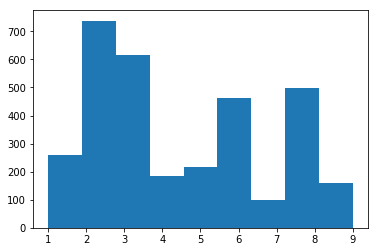

In [70]:
# Plot Facies of all wells
print('The facies are {}'.format(np.unique(data['Facies'])))
plt.hist(data['Facies'], bins=9)

The nine discrete facies (classes of rocks) are: 
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

## prep for CNN

In [71]:
def prepare_feature_vectors(data, features, window_width):

    raw_feature_vectors = data[features]
    well_labels = data['Well Name']
    num_features = np.shape(raw_feature_vectors)[1]

    output = np.zeros((1, window_width, num_features))
    for x in well_labels.unique():
        well = raw_feature_vectors[well_labels == x].values
        well = np.concatenate((np.repeat(well[0:1], np.floor((window_width-1)/2.0), axis=0), well,
                              np.repeat(well[-1:None], np.floor(window_width/2.0), axis=0)), axis=0)

        tmp = np.zeros((np.size(well, axis=0) - window_width + 1, window_width, num_features))
        for i in np.arange(np.size(well, axis=0) - window_width + 1):
            tmp[i] = np.reshape(well[i: i + window_width], (window_width, num_features))

        output = np.append(output, tmp, axis=0)

    return output[1:]

In [72]:
# Window around central value and list the six features we are using
window_width = 15
feature_list = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'NM_M', 'RELPOS']
X_train = prepare_feature_vectors(data[data['PE'].notnull()], feature_list, window_width)
num_train_samples = np.asarray(np.shape(X_train))[0]

X_test = prepare_feature_vectors(data[data['PE'].isnull()], feature_list, window_width)
num_test_samples = np.asarray(np.shape(X_test))[0]

print('Training Samples=', num_train_samples, '   Test Samples=', num_test_samples)

Training Samples= 3232    Test Samples= 0


In [73]:
# define training parameters and prepare arrays to store training metrics
epochs_per_fold = 1000
num_fold = 5
roll_stride = np.ceil(num_train_samples/num_fold).astype(int)

cnn_hist = History()
hist = np.zeros((4, num_fold, epochs_per_fold))
f1scores = np.zeros(num_fold)
Y_test = np.zeros((num_test_samples, num_fold))


# shuffle input data
#rand_perm = np.random.permutation(num_train_samples)
#X_train = X_train[rand_perm]
#Y_train = Y_train[rand_perm]

X_train = np.random.shuffle(X_train)
Y_train = np.random.shuffle(Y_train)

At this point, we have a training dataset with imputed PE so we can proceed with the facies classification.

In [74]:
# Read in two test wells
blind_wells = pandas.read_csv('nofacies_data.csv')
blind_wells.describe()

# test data is clean as well

,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,830.000000,830.00000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,2987.070482,57.61173,0.666312,2.851964,11.655277,3.654178,1.678313,0.535807
std,94.391925,27.52774,0.288367,3.442074,5.190236,0.649793,0.467405,0.283062
min,2808.000000,12.03600,-0.468000,-8.900000,1.855000,2.113000,1.000000,0.013000
25%,2911.625000,36.77325,0.541000,0.411250,7.700000,3.171500,1.000000,0.300000
50%,2993.750000,58.34450,0.675000,2.397500,10.950000,3.515500,2.000000,0.547500
75%,3055.375000,73.05150,0.850750,4.600000,14.793750,4.191500,2.000000,0.778000
max,3160.500000,220.41300,1.507000,16.500000,31.335000,6.321000,2.000000,1.000000


In [75]:
# Convert facies class to one-hot-vector representation
num_classes = data['Facies'].unique().size
Y_train = np_utils.to_categorical(data['Facies'].values-1, num_classes)

# Window around central value and define the seven features we are using
window_width = 15
feature_list = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
X_train = prepare_feature_vectors(data, feature_list, window_width)
X_test = prepare_feature_vectors(blind_wells, feature_list, window_width)

num_train_samples = np.asarray(np.shape(X_train))[0]
num_test_samples = np.asarray(np.shape(X_test))[0]

print('Training Samples=', num_train_samples, '   Test Samples=', num_test_samples)

Training Samples= 3232    Test Samples= 830


In [91]:
# define neural network to classify facies
num_filters = 12
dropout_prob = 0.6

convnet = Sequential()
convnet.add(Conv1D(num_filters, 1, padding='valid', input_shape=(window_width, len(feature_list))))
convnet.add(Activation('relu'))
convnet.add(Conv1D(7, 1, padding='valid'))
convnet.add(Activation('relu'))
convnet.add(Conv1D(num_filters, 3, padding='valid'))
convnet.add(Activation('relu'))
convnet.add(Dropout(dropout_prob / 2))

convnet.add(Flatten())
convnet.add(Dense(4 * num_filters))
convnet.add(normalization.BatchNormalization())
convnet.add(Activation('sigmoid'))
convnet.add(Dropout(dropout_prob))

convnet.add(Dense(num_classes, activation=(tf.nn.softmax)))
#convnet.add(Dense(num_classes))
#convnet.add(Activation('softmax'))
convnet.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
convnet.summary()

# save initial weights
initial_weights = convnet.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_48 (Conv1D)           (None, 15, 12)            96        
_________________________________________________________________
activation_67 (Activation)   (None, 15, 12)            0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 15, 7)             91        
_________________________________________________________________
activation_68 (Activation)   (None, 15, 7)             0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 13, 12)            264       
_________________________________________________________________
activation_69 (Activation)   (None, 13, 12)            0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 13, 12)            0         
__________

In [97]:
# define training parameters and prepare arrays to store training metrics
epochs_per_fold = 1000
num_fold = 6
roll_stride = np.ceil(num_train_samples/num_fold).astype(int)

convnet_hist = History()
hist = np.zeros((4, num_fold, epochs_per_fold))
f1scores = np.zeros(num_fold)
Y_test_ohv = np.zeros((num_test_samples, num_fold, num_classes))


# shuffle input data
rand_perm = np.random.permutation(num_train_samples)
X_train = X_train[rand_perm]
Y_train = Y_train[rand_perm]

In [98]:
# use 6-fold cross validation and train 6 neural networks, ending up with 6 sets of predictions
for i in np.arange(num_fold):
    convnet.set_weights(initial_weights)
    X_train = np.roll(X_train, i*roll_stride, axis=0)
    Y_train = np.roll(Y_train, i*roll_stride, axis=0)

    convnet.fit(X_train, Y_train, batch_size=200, epochs=epochs_per_fold, verbose=0,
                validation_split=1.0/num_fold, callbacks=[convnet_hist])

    hist[:, i, :] = [convnet_hist.history['acc'], convnet_hist.history['val_acc'],
                     convnet_hist.history['loss'], convnet_hist.history['val_loss']]

    Y_predict = 1 + np.argmax(convnet.predict(X_train), axis=1)
    f1scores[i] = metrics.f1_score(1 + np.argmax(Y_train, axis=1), Y_predict, average='micro')
    print('F1 Score =', f1scores[i])

    Y_test_ohv[:, i, :] = convnet.predict(X_test)
    
print('Average F1 Score =', np.mean(f1scores))

F1 Score = 0.6989480198019802
F1 Score = 0.7051361386138614
F1 Score = 0.7100866336633663
F1 Score = 0.7165841584158416
F1 Score = 0.6478960396039604
F1 Score = 0.6556311881188119
Average F1 Score = 0.6890470297029703


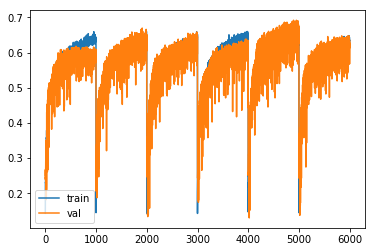

In [99]:
# Plot callbacks
hist = np.reshape(hist, (4, num_fold * epochs_per_fold))
plt.plot(hist[0]); plt.plot(hist[1])
plt.legend(['train', 'val'], loc='lower left')

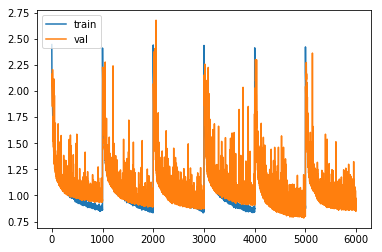

In [100]:
plt.plot(hist[2]); plt.plot(hist[3])
plt.legend(['train', 'val'], loc='upper left')

In [103]:
# Soft majority voting on 6 predictions to produce final prediction 
Y_test = 1 + np.argmax(np.sum(Y_test_ohv, axis=1), axis=1)

# Append predictions to dataframe and write to file
blind_wells['Facies'] = Y_test
blind_wells.to_csv('predicted_facies_v1.csv', index=False)